In [20]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline
import numpy as np
import seaborn as sns
import itertools

from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import StratifiedShuffleSplit

# Data Inputting

In [2]:
df = pd.read_csv('advertising.csv')
df.drop('City', axis=1, inplace=True)
df.head()

Daily Time Spent on Site  Age  Area Income  Daily Internet Usage  \
0                     68.95   35     61833.90                256.09   
1                     80.23   31     68441.85                193.77   
2                     69.47   26     59785.94                236.50   
3                     74.15   29     54806.18                245.89   
4                     68.37   35     73889.99                225.58   

                           Ad Topic Line  Male     Country  \
0     Cloned 5thgeneration orchestration     0     Tunisia   
1     Monitored national standardization     1       Nauru   
2       Organic bottom-line service-desk     0  San Marino   
3  Triple-buffered reciprocal time-frame     1       Italy   
4          Robust logistical utilization     0     Iceland   

             Timestamp  Clicked on Ad  
0  2016-03-27 00:53:11              0  
1  2016-04-04 01:39:02              0  
2  2016-03-13 20:35:42              0  
3  2016-01-10 02:31:19              0  
4  2016-06-03 03:36:18              0

# Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   Male                      1000 non-null   int64  
 6   Country                   1000 non-null   object 
 7   Timestamp                 1000 non-null   object 
 8   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 70.4+ KB


In [4]:
df.describe()

Daily Time Spent on Site          Age   Area Income  \
count               1000.000000  1000.000000   1000.000000   
mean                  65.000200    36.009000  55000.000080   
std                   15.853615     8.785562  13414.634022   
min                   32.600000    19.000000  13996.500000   
25%                   51.360000    29.000000  47031.802500   
50%                   68.215000    35.000000  57012.300000   
75%                   78.547500    42.000000  65470.635000   
max                   91.430000    61.000000  79484.800000   

       Daily Internet Usage         Male  Clicked on Ad  
count           1000.000000  1000.000000     1000.00000  
mean             180.000100     0.481000        0.50000  
std               43.902339     0.499889        0.50025  
min              104.780000     0.000000        0.00000  
25%              138.830000     0.000000        0.00000  
50%              183.130000     0.000000        0.50000  
75%              218.792500     1.000000        1.00000  
max              269.960000     1.000000        1.00000

In [5]:
df.nunique()

Daily Time Spent on Site     900
Age                           43
Area Income                 1000
Daily Internet Usage         966
Ad Topic Line               1000
Male                           2
Country                      237
Timestamp                   1000
Clicked on Ad                  2
dtype: int64

In [6]:
nums = list(df.select_dtypes(exclude=['object']).columns)
cats = list(df.select_dtypes(include=['object']).columns)

In [7]:
cats.remove('Ad Topic Line')
cats.remove('Timestamp')

nums.remove('Clicked on Ad')
nums.remove('Male')

print(cats)
print(nums)

['Country']
['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']


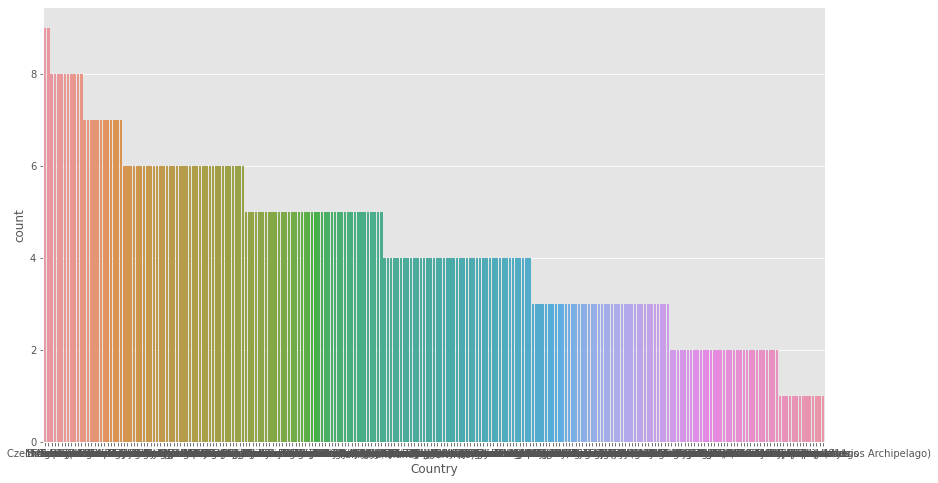

In [8]:
figure = plt.figure(1,(14,8))
for cat in cats:
    sns.countplot(x=cat,data=df,order=df[cat].value_counts().index)

plt.show()

<AxesSubplot:>

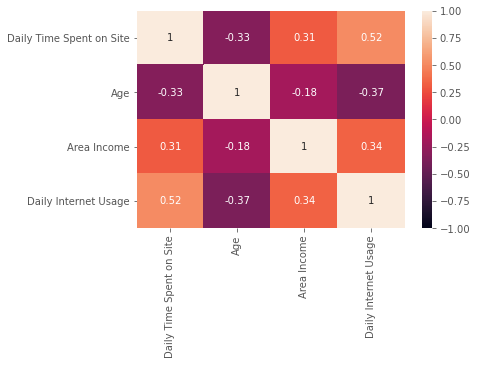

In [9]:
sns.heatmap(df[nums].corr(), annot=True,vmin=-1,vmax=1)

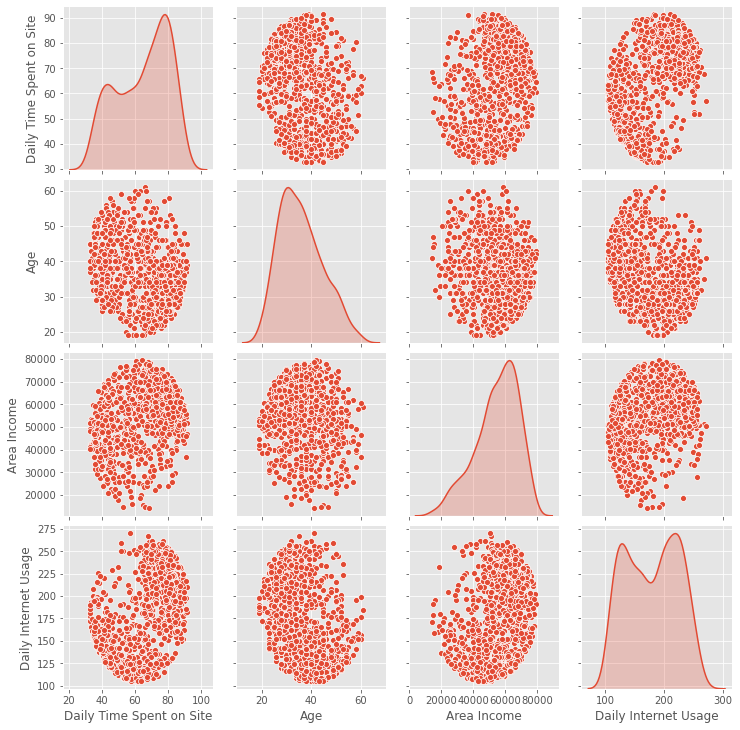

In [10]:
sns.pairplot(df[nums], diag_kind="kde")

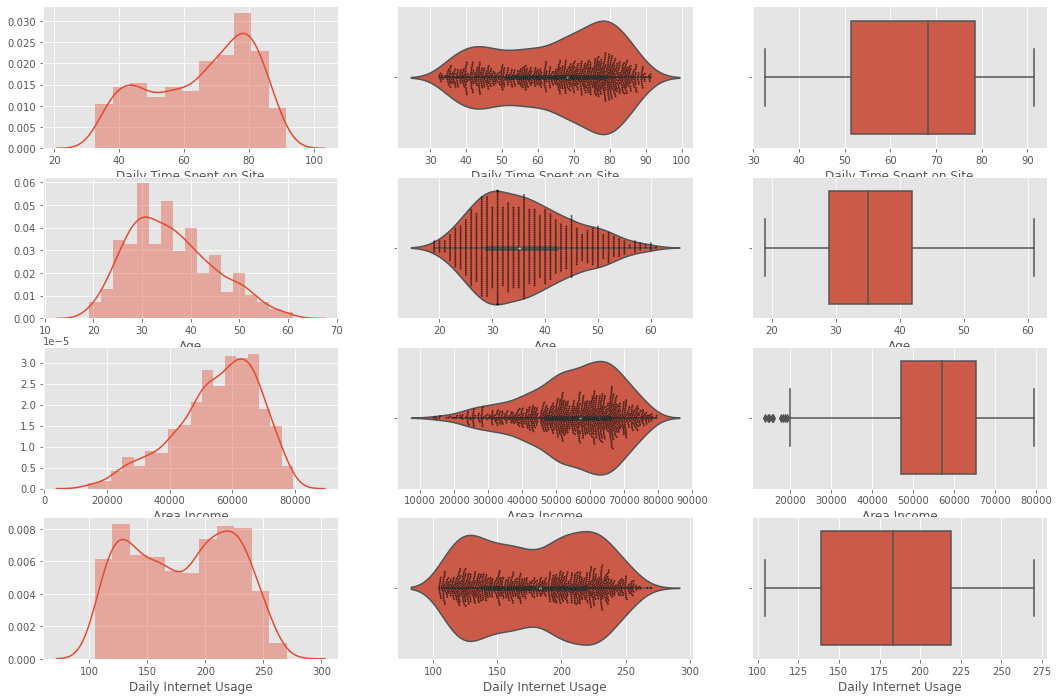

In [24]:
cols = 3
rows = len(nums)
figure = plt.figure(1,(18,rows*3))
i = 0
for num_feature in nums:
    i += 1
    ax1 = plt.subplot(rows,cols,i)
    sns.distplot(df[num_feature])
    
    i += 1
    ax2 = plt.subplot(rows,cols,i)
    sns.violinplot(df[num_feature])
    sns.swarmplot(df[num_feature], alpha=0.6,size=2, color="k")
    
    i += 1
    ax3 = plt.subplot(rows,cols,i)
    sns.boxplot(df[num_feature])

# Pipelines

In [6]:
date_cols = ["Timestamp"]
cat_cols = ['Country']
ad_line_cols = ['Ad Topic Line']
label_col = ['Clicked on Ad']

In [7]:
class DataFrameSelector(TransformerMixin, BaseEstimator):
    def __init__(self, arr):
        self.arr = arr
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.arr].to_numpy()

In [8]:
class MyLabelBinarizer(TransformerMixin, BaseEstimator):
    def __init__(self, cat_cols):
        self.cat_cols = cat_cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col_index in range(len(X[0])):
            column = X[:, col_index]
            binarizer = LabelBinarizer()
        
            one_hot_encoded_array = binarizer.fit_transform(column)
            classes = binarizer.classes_
            
            for ind_class in classes:
                self.cat_cols.append(ind_class)
                
            X = np.c_[X, one_hot_encoded_array]

        return X

In [9]:
class DateConverter(TransformerMixin, BaseEstimator):
    def __init__(self, date_cols):
        self.date_str_format = "%Y-%m-%d %H:%M:%S"
        self.date_cols = date_cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        time_of_days = []
        
        for row_index in range(len(X)):
            str_datetime = X[row_index,0]
            new_datetime = datetime.strptime(str_datetime, self.date_str_format)
            X[row_index,0] = new_datetime
            hour = new_datetime.hour
            time_of_day = ""
            if hour > 20 or hour < 5:
                time_of_day = "night"
            elif hour < 12:
                time_of_day = "morning"
            elif hour < 17:
                time_of_day = "afternoon"
            else:
                time_of_day = "evening"
            time_of_days.append(time_of_day)
        
        lb = LabelBinarizer()
        one_hot_encoded_time_of_days = lb.fit_transform(time_of_days)
        
        for cl in lb.classes_:
            self.date_cols.append(cl)
        X = np.c_[X,one_hot_encoded_time_of_days]
        
        return X

In [10]:
class AdTopicLineLengthAddition(TransformerMixin, BaseEstimator):
    def __init__(self, ad_line_cols):
        self.ad_line_cols = ad_line_cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        length_arr = []
        word_length_arr = []
        
        for i in X:
            length_arr.append(len(i[0]))
        
            word_length = 0
            for letter in i[0]:
                if letter == ' ':
                    word_length += 1
            
            word_length_arr.append(word_length + 1)
        
        self.ad_line_cols.append('Ad Line Length')
        self.ad_line_cols.append('Ad Line Word Length')
        
        length_arr = np.array(length_arr)
        word_length_arr = np.array(word_length_arr)
        
        length_arr = ( length_arr - length_arr.mean() ) / length_arr.std()
        word_length_arr = ( word_length_arr - word_length_arr.mean() ) / word_length_arr.std()
    
        return np.c_[X, length_arr, word_length_arr]

In [13]:
num_pipeline = Pipeline([
    ('data_selector', DataFrameSelector(nums)), 
    ('standard_scaler', StandardScaler())
])

In [14]:
cat_pipeline = Pipeline([
    ('data_selector', DataFrameSelector(cats)), 
    ('label_binarizer', MyLabelBinarizer(cat_cols))
])

In [15]:
date_pipeline = Pipeline([
    ('data_selector', DataFrameSelector(date_cols)), 
    ('date_converter', DateConverter(date_cols))
])

In [16]:
ad_line_length = Pipeline([
    ('data_selector', DataFrameSelector(ad_line_cols)),
    ('ad_line_length_feature', AdTopicLineLengthAddition(ad_line_cols))
])

In [17]:
add_label = Pipeline([
    ('data_selector', DataFrameSelector(['Clicked on Ad']))
])

In [18]:
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
    ('date_pipeline',date_pipeline),
    ('ad_line_length', ad_line_length),
    ('add_label', add_label)
])

# Data Separation

In [19]:
test_size = 0.2

X = df.loc[:, 'Daily Time Spent on Site': 'Timestamp']
y = df['Clicked on Ad']

In [20]:
# stratified on the 'Clicked on Ad' column for proper distributions

shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in shuffle_split.split(X, y):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

# Creating Train and Test CSV files

In [21]:
train_set.head()

Daily Time Spent on Site  Age  Area Income  Daily Internet Usage  \
747                     49.13   32     41097.17                120.49   
586                     78.29   38     57844.96                252.07   
519                     35.00   40     46033.73                151.25   
770                     71.14   30     69758.31                224.82   
600                     84.00   48     46868.53                136.21   

                                         Ad Topic Line  Male          Country  \
747                   Optimized intermediate help-desk     0             Fiji   
586              Networked regional Local Area Network     0          Liberia   
519  Fully-configurable context-sensitive Graphic I...     1         Mongolia   
770                      Assimilated stable encryption     0           France   
600                          Inverse discrete extranet     1  Kyrgyz Republic   

               Timestamp  Clicked on Ad  
747  2016-01-29 00:45:19              1  
586  2016-01-05 20:58:42              0  
519  2016-06-18 16:02:34              1  
770  2016-06-21 00:52:47              0  
600  2016-04-17 05:08:52              1

In [23]:
train_cleaned = full_pipeline.fit_transform(train_set)

In [24]:
columns = nums + cat_cols + date_cols + ad_line_cols + label_col
train_cleaned = pd.DataFrame(data=train_cleaned, columns=columns)

In [25]:
train_cleaned.head()

Daily Time Spent on Site       Age Area Income Daily Internet Usage  \
0                 -1.00327 -0.475928    -1.07451             -1.36901   
1                 0.838468  0.211953    0.176047              1.63719   
2                 -1.89571  0.441247   -0.705899            -0.666237   
3                 0.386877 -0.705222     1.06562              1.01461   
4                  1.19911   1.35842   -0.643565             -1.00985   

           Country Afghanistan Albania Algeria American Samoa Andorra  ...  \
0             Fiji           0       0       0              0       0  ...   
1          Liberia           0       0       0              0       0  ...   
2         Mongolia           0       0       0              0       0  ...   
3           France           0       0       0              0       0  ...   
4  Kyrgyz Republic           0       0       0              0       0  ...   

  Zimbabwe            Timestamp afternoon evening morning night  \
0        0  2016-01-29 00:45:19         0       0       0     1   
1        0  2016-01-05 20:58:42         0       1       0     0   
2        0  2016-06-18 16:02:34         1       0       0     0   
3        0  2016-06-21 00:52:47         0       0       0     1   
4        0  2016-04-17 05:08:52         0       0       1     0   

                                       Ad Topic Line Ad Line Length  \
0                   Optimized intermediate help-desk       -0.24776   
1              Networked regional Local Area Network       0.629266   
2  Fully-configurable context-sensitive Graphic I...        3.61116   
3                      Assimilated stable encryption      -0.773976   
4                          Inverse discrete extranet        -1.4756   

  Ad Line Word Length Clicked on Ad  
0           -0.451417             1  
1             3.72354             0  
2             1.63606             1  
3           -0.451417             0  
4           -0.451417             1  

[5 rows x 248 columns]

In [26]:
train_cleaned.to_csv('train.csv', index=False)